# Analysing twitter archives

In [1]:
# Customise these variables for your own setup!
TWEETS_PATH = "archive_dir/twitter-archive-20180528/tweets.csv"
TWEETS_USERNAME = "@caitelatte"
VERBOSE_RESULTS = True

## Setup: Read `tweets.csv`

**Goal:** read the contents of the `tweets.csv` file into a list called `tweets`.

### Notes

-   I learnt that the `csv` module has a tool `DictReader` to read a CSV file as a dictionary, and pull out the field names from the first row. Each tweet is represented as an `OrderedDict`, which looks a lot like a list of tuples of field name and contents. This should be real nice to use!
-   While working on optimising the first example I found a nice way to handle dates with the `matplotlib.dates` module.

In [2]:
import csv
import pprint

# load tweets from csv
tweets = []
with open(TWEETS_PATH) as tweetsfile:
    tweetsReader = csv.DictReader(tweetsfile)
    fields = tweetsReader.fieldnames
    for tweet in tweetsReader:
        tweets.append(tweet)

if VERBOSE_RESULTS:
    print("I found {0} tweets!".format(len(tweets)))
    print("Each tweet will have the following fields: {fields}".format(
        fields=fields
    ))
    print("The first tweet in this list looks like:")
    pprint.pprint(tweets[0], width=70)

I found 4664 tweets!
Each tweet will have the following fields: ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls']
The first tweet in this list looks like:
OrderedDict([('tweet_id', '1.00065E+18'),
             ('in_reply_to_status_id', '1.00062E+18'),
             ('in_reply_to_user_id', '6603532'),
             ('timestamp', '2018-05-27 07:50:33 +0000'),
             ('source',
              '<a href="http://twitter.com/download/android" '
              'rel="nofollow">Twitter for Android</a>'),
             ('text',
              '@b0rk My favourite tip is that you can replace the '
              "'/' with an arbitrary special character (I often use "
              "#, there are a few you can't use) in sed commands so "
              "you don't have to escape / in path names :)"),
             ('retweeted_status_id', ''),
             ('retweeted

In [3]:
import matplotlib.dates as mdates
import datetime

def tweet_time_mdate(tweet_ts):
    """Return an mdate format of the timestamp in a tweet!
    
    Expects `tweet_ts` to be in format %Y-%m-%d %H:%M:%S %z.
    """
    tweet_dt = datetime.datetime.strptime(tweet["timestamp"], "%Y-%m-%d %H:%M:%S %z")
    return mdates.date2num(tweet_dt)

## Output 1: Basic tweet frequency

**Goal:** a frequency histogram with the number of tweets per a given time period.

### Notes:

-   `datetime.datetime.strptime` is a function to parse a formatted string and return a `datetime.datetime` object. For documentation on how to format the format string, the best place to look is `help(time.strptime)`.
-   I was originally going to write a list comprehension to enumerate each week between the first and last tweets available, but found out that `pandas` just *does this* with `pandas.date_range`. Amazing!
-   After all that, it turns out I didn't need a date-range anyway, as matplotlib.pyplot actually has a `hist` function which auto-computes "bins" by itself.
-   Dealing with all these tweets takes time if they're in `datetime.datetime` format... `matplotlib.dates` is a solution! I made a function above, `tweet_time_mdate` to take a string formatted like `2018-07-27 08:02:00 +0000` and return a `matplotlib.dates`.

In [4]:
#  Now I want to generate a list of timestamps
# (in python datetime.datetime format)
import datetime
import matplotlib.dates as mdates

tweet_times = []
tweet_dates = []
tweet_mpldates = []
for tweet in tweets:
    tweet_ts = datetime.datetime.strptime(tweet["timestamp"], "%Y-%m-%d %H:%M:%S %z")
    tweet_times.append(tweet_ts)
    tweet_dates.append(tweet_ts.date())
    tweet_mpldates.append(tweet_time_mdate(tweet["timestamp"]))

if VERBOSE_RESULTS:
    print("I have collected {0} datetimes into `tweet_times`, and the first one looks like {1}.".format(
        len(tweet_times), (tweet_times[0], tweet_dates[0], tweet_mpldates[0])))

I have collected 4664 datetimes into `tweet_times`, and the first one looks like (datetime.datetime(2018, 5, 27, 7, 50, 33, tzinfo=datetime.timezone.utc), datetime.date(2018, 5, 27), 736841.3267708333).


In [5]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# use this section for limiting numbers for performance
tweet_mpldates_subset = tweet_mpldates[:500]

# # Make a collection of frequency buckets with dates (not necessary due to plt.hist!)
# import pandas.date_range
# timediff = datetime.timedelta(days=7)
# first_time = tweet_times[-1]
# last_time = tweet_times[0]
# print(first_time, last_time)

# # Setting up a structure of date buckets for frequencies to go in
# time_buckets = pandas.date_range(start=first_time, end=last_time, freq=timediff)
# times_dict = []
# for t_bucket in time_buckets:
#     times_dict.append((t_bucket, 0))

fig, ax = plt.subplots(1, 1)
n, bins, patches = ax.hist(tweet_mpldates_subset, bins=24, stacked=True, color='teal')

plt.xlabel("Dates")
plt.ylabel("Tweets")
plt.title("Histogram of Tweets by {username}".format(
    username=TWEETS_USERNAME))
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))

plt.show()

<Figure size 640x480 with 1 Axes>

## Output 2: People interactions
**Goal:** a representation of all the people I've mentioned over time.

1. **Identify data structure goal:** list of tuples of usernames and timestamps
2. **Extract the necessary data**:
    - `USERNAME_REGEX = r"(@\w+)"` (an @ symbol followed by word only characters)
    - made the tweet_time_mdate function to avoid rewriting the same code as in the previous output
    - tested with a slice of 100 tweets for speed
    - `just_usernames` is a sorted list of all usernames
    - `timed_usernames` is a list of tuples `(username, tweet_mdate)`
3. **Present the data**

In [6]:
import re

# how can I recognise that a tweet has usernames?
USERNAME_REGEX = r"(@\w+)"

timed_usernames = []
just_usernames = []

for tweet in tweets:
    tweet_mdate = tweet_time_mdate(tweet.get("timestamp"))
    usernames = re.findall(USERNAME_REGEX, tweet.get("text"))
    for username in usernames:
        timed_usernames.append((username, tweet_mdate))
        just_usernames.append(username)
        
just_usernames = sorted(just_usernames)

print("I've sorted {count} username mentions!".format(
    count=len(just_usernames)))

I've sorted 5305 username mentions!


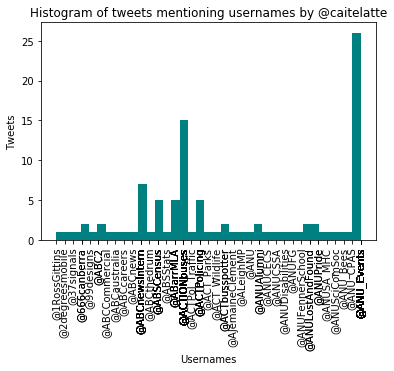

In [7]:
import matplotlib.pyplot as plt

# use this section for limiting numbers for performance
usernames_subset = just_usernames[:100]
uniq_usernames = set(usernames_subset)

fig, ax = plt.subplots(1, 1)
n, bins, patches = ax.hist(usernames_subset, bins=len(uniq_usernames), stacked=True, color='teal')

plt.xlabel("Usernames")
plt.ylabel("Tweets")
plt.title("Histogram of tweets mentioning usernames by {username}".format(
    username=TWEETS_USERNAME))
# locator = mdates.AutoDateLocator()
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
plt.xticks(usernames_subset, label=None, rotation='vertical')
plt.axis("tight")

plt.show()

Ok great! I made a graph, but this isn't very useful... Maybe a table would be better in this case?

**New goal:** Display a table of the most frequent mentionees.

**New tool:** numpy! specifically  [`numpy.unique`!](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) - hinted from [Stack Overflow question "Numpy - Most efficient frequency counts for unique values in an array?](https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array)

In [8]:
import numpy as np

(uniq_usernames, count_usernames) = np.unique(just_usernames, return_counts=True)

zipped_usernames_freq = []

for zipzip in zip(uniq_usernames, count_usernames):
#     print(zipzip)
    zipped_usernames_freq.append(zipzip)

# this sorts the counts as strings (eg '9' > '13')
# as numpy makes their arrays homogeneous
# print(np.sort(np.asarray((uniq_usernames, count_usernames))).T)
# # also it's wrong???

tuple_freqs_usernames = sorted(zipped_usernames_freq, key=lambda zipzip: zipzip[-1], reverse=True)

print("The top 10 usernames I've mentioned are:")
for (user, count) in tuple_freqs_usernames[:10]:
    print(" {user}: {count}".format(user=user, count=count))
    
print("There were {count} usernames I only mentioned once!".format(
    count=len(list(filter(lambda x: x[-1] ==1, zipped_usernames_freq)))
))


The top 10 usernames I've mentioned are:
 @merxplat: 642
 @LibideeB: 617
 @caitelatte: 105
 @wjoneil: 88
 @ajdlinux: 85
 @scumsies: 68
 @helenperris: 66
 @clareology: 65
 @Ducky_Tape: 58
 @ANU_Events: 56
There were 836 usernames I only mentioned once!


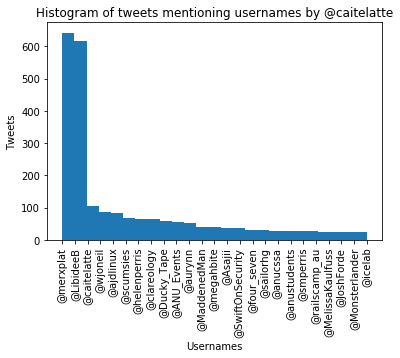

In [9]:
"""Make a histogram with just the top 100 usernames!"""

import matplotlib.pyplot as plt

# use this section for limiting numbers for performance
usernames_subset, top_counts = zip(*tuple_freqs_usernames[:25])
uniq_usernames = set(usernames_subset)

fig, ax = plt.subplots(1, 1)
n, bins, patches = ax.hist(usernames_subset, bins=len(uniq_usernames), weights=top_counts, stacked=True)

plt.xlabel("Usernames")
plt.ylabel("Tweets")
plt.title("Histogram of tweets mentioning usernames by {username}".format(
    username=TWEETS_USERNAME))
# locator = mdates.AutoDateLocator()
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
plt.xticks(usernames_subset, label=None, rotation='vertical')
plt.axis("tight")
plt.set_cmap("ocean")

plt.show()

## Output 3: Sentiment analysis!

**TODO**

## Notes/help messages

In [10]:
# all the help messages i needed
# import datetime
# help(datetime.datetime.strptime)
# import time
# help(time.strptime)
# import matplotlib
# help(matplotlib)
# import datetime
# help(datetime.datetime)
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.

